<a href="https://colab.research.google.com/github/meskeremg/FinalCapstone/blob/main/Step_4_2_NLP_Book_Recommendation_Gensim_and_Spacy_Meskerem_Goshime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 4-2: NLP Book Recommendation System
# Model 2 - Gensim and Spacy

Amazon Books Reviews Data data source: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews?select=books_data.csv This is a rich dataset for Natural Language Processing containing 3,000,000 text reviews from users as well as text descriptions and categories for 212,403 books. Therefore it is ideal for text analysis.

# Importing libraries and reading the data

In [ ]:
!python3 -m spacy download en_core_web_lg

2022-12-18 22:14:05.510511: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import pandas as pd
import numpy as np
import os
import gensim
import spacy
import en_core_web_lg
nlp = spacy.load('en_core_web_lg')


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1dnURk-tdodpKuv-3Ic92ELyNoQLs9tLA'})
fileDownloaded.GetContentFile('books_after_preprocessing.csv')

In [ ]:
books = pd.read_csv('books_after_preprocessing.csv')

In [ ]:
books.head(3)

,index,Title,review/score_Avg,review/score_Count,authors,publishedDate,description_categories
0,74190,and poetry is born russian classical poetry,4.0,1.0,['Aleksandr Sergeevich Pushkin'],1984.0,russian poetry selection russian poem russian ...
1,80644,and still king,4.0,1.0,['Keith Checkley'],2012.0,business economics nothing provides clearer pi...
2,31352,dancers in mourning,4.5,8.0,['Margery Allingham'],2015.0,fiction murder take center stage songanddance ...


# Taking a subset of the data by selecting the books which received more than 10 reviews

I am taking a subset of the book data to preform Sentence Embeddings and Cosine Similarity. The full dataset would be too large to process.

In [ ]:
books_sm_10 = books[books['review/score_Count'] > 10]
books_sm_10.head(3)

,index,Title,review/score_Avg,review/score_Count,authors,publishedDate,description_categories
30,95768,1 is one,4.866667,30.0,['Tasha Tudor'],2015.0,juvenile nonfiction rhyming verse present numb...
34,76202,1 ragged ridge road,4.277778,18.0,"['Leonard Foglia', 'David Richards']",1998.0,fiction estranged husband carol robbins young ...
36,110134,10 button book,3.142857,28.0,['William Accorsi'],1999.0,juvenile nonfiction verse introduce number one...


In [ ]:
books_sm_10 = books_sm_10.reset_index(drop=True)
books_sm_10 = books_sm_10.drop(columns='index')
books_sm_10.head(3)


,Title,review/score_Avg,review/score_Count,authors,publishedDate,description_categories
0,1 is one,4.866667,30.0,['Tasha Tudor'],2015.0,juvenile nonfiction rhyming verse present numb...
1,1 ragged ridge road,4.277778,18.0,"['Leonard Foglia', 'David Richards']",1998.0,fiction estranged husband carol robbins young ...
2,10 button book,3.142857,28.0,['William Accorsi'],1999.0,juvenile nonfiction verse introduce number one...


In [ ]:
books_sm_10.shape

(29560, 6)

# Creating vectors from the description_categories column

In [ ]:
# Source: https://www.youtube.com/watch?v=Il04RjS-9-8&t=262s

# Creating a column for vectors
books_sm_10['vectors'] = ''

In [ ]:
# Create vectors from the description_categories column
# This took about 7 minutes to run with GPU and Hi RAM.

for i in range(len(books_sm_10['description_categories'])):
    books_sm_10['vectors'][i] = nlp(books_sm_10['description_categories'][i])

<ipython-input-12-694ec382e2c4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_sm_10['vectors'][i] = nlp(books_sm_10['description_categories'][i])


In [ ]:
books_sm_10['vectors'].head()

0    (juvenile, nonfiction, rhyming, verse, present...
1    (fiction, estranged, husband, carol, robbins, ...
2    (juvenile, nonfiction, verse, introduce, numbe...
3    (family, relationship, repeat, everything, eve...
4    (reference, jumpstart, reading, skill, speed, ...
Name: vectors, dtype: object

# Computing similarity scores between the book in the 0 index place and all the books

In [ ]:
# Similarity between books in the 0 and 1 index place

books_sm_10['vectors'][0].similarity(books_sm_10['vectors'][1])

0.594082225178606

In [ ]:
# computing similarity scores between the book in the 0 index place and all of the books, including itself
# I expected this cell to take a while to run. However, it run in few seconds. 
# However, please note that we are computing similarity for only one book at a time, not the whole dataset at once as
# in the case of SBERT Sentence Transformers.

sims = []
index = []
for i in range(len(books_sm_10['vectors'])):
  sim = books_sm_10['vectors'][i].similarity(books_sm_10['vectors'][0])
  sims.append(sim)
  index.append(i)

sims_df = pd.DataFrame(sims, index=index, columns =['sims'])

In [ ]:
# The top 5 highest similarity scores. 
# I used index [1:6] to exclude the similarity score of the book to itself, which would be a similarity score of 1.
top5 = sims_df.sort_values(by='sims', ascending=False)
top5 = top5[1:6]
top5 = top5.reset_index()
top5

,index,sims
0,28380,0.890873
1,28730,0.881430
2,22012,0.879250
3,6160,0.879250
4,17511,0.875732


In [ ]:
# Taking the top 5 index values
index = top5['index'].values
index

array([28380, 28730, 22012,  6160, 17511])

In [ ]:
print('Chosen book: ')
print(books_sm_10['Title'][0], '\n')
print('Recommended books: ')
for i in index:
  print(books_sm_10['Title'][i])

Chosen book: 
1 is one 

Recommended books: 
way out in the desert
when we were very young winniethepooh winniethepooh series
the dictionary of the khazars
dictionary of the khazars a lexicon novel in 100000 words english and serbocroatian edition
richard scarrys best mother goose ever


# Creating a Function that searches the top 5 similar books

In [ ]:
def find_similar(Title):

  chosen_index = books_sm_10[books_sm_10['Title'] == Title].index[0]
  #chosen_index

  sims = []
  index = []

  for i in range(len(books_sm_10['vectors'])):
    sim = books_sm_10['vectors'][i].similarity(books_sm_10['vectors'][chosen_index])
    sims.append(sim)
    index.append(i)

  sims_df = pd.DataFrame(sims, index=index, columns =['sims'])
  
  top5 = sims_df.sort_values(by='sims', ascending=False)
  top5 = top5[1:6]
  top5 = top5.reset_index()
  #top5

  index = top5['index'].values

  print('Chosen book: ')
  print('Title: ', books_sm_10['Title'][chosen_index])
  print('Description: ', books_sm_10['description_categories'][chosen_index], '\n')
  print('Recommended books: ')
  for i in index:
    print('Title: ', books_sm_10['Title'][i])
    print('Description: ', books_sm_10['description_categories'][i])

# Example Recommendations with the same books I used to test Model 1 and Model 3

In [ ]:
# Chosen title
chosen_title = '1 is one'
find_similar(chosen_title)

Chosen book: 
Title:  1 is one
Description:  juvenile nonfiction rhyming verse present number one twenty illustration animal flower child 

Recommended books: 
Title:  way out in the desert
Description:  juvenile fiction counting book rhyme present various desert animal child mother horned toad little toadie one mom tarantula little spider ten numeral hidden illustration
Title:  when we were very young winniethepooh winniethepooh series
Description:  juvenile fiction milne beloved collection poetryfeaturing first appearance winniethepooh composed dozen poem author delighted generation child adult alike character winniethepooh christopher robin piglet eeyore young warm whimsical journey childhood includes classic verse halfway teddy bear introduced pooh world zoo king breakfast shoe stocking buckingham palace plus many
Title:  the dictionary of the khazars
Description:  fiction national bestseller dictionary khazars cited new york time book review one best book year written two version 

One of the recommendations, **The dictionary of the khazars** is a very different book from the chosen book. It is a 339 page novel for adults about imiaginary people living somewhere in Europe. Unfortunately, this title appears twice in the recommendation with variant titles. The rest of the recommendations are rhyming early childhood picture books like the chosen title. I am not satisfied with this recommendation.

In [ ]:
chosen_title = 'spanish stepbystep'
find_similar(chosen_title)

Chosen book: 
Title:  spanish stepbystep
Description:  foreign language study proven grammarbased approach give real mastery spanish language use advanced spanish step step progressive grammarbased approach conquer intermediate advanced spanishlanguage topic stepbystep approach give real confidence tool need achieve high spanish proficiency youll get quick review key grammar basic move advanced topic need true mastery language complete coverage verb tense beyond present past irregular verb sentence structure part speech book give thorough overview advanced grammar topic also introduces hundred new vocabulary word reinforced reading put new term everyday context 

Recommended books: 
Title:  teach yourself turkish complete course turkish edition
Description:  foreign language study complete turkish comprehensive book audio language course take beginner intermediate level new edition successful course fully revised packed new learning feature give language practice skill communicate conf

All of the recommended books are language learning books. However, I would hope to get at least a few for the Spanish language specifically.
I am not happy with this recommendation either.

In [ ]:
chosen_title = 'to kill a mockingbird'
find_similar(chosen_title)

Chosen book: 
Title:  to kill a mockingbird
Description:  fiction voted america bestloved novel pbs great american read harper lee pulitzer prizewinning masterwork honor injustice deep southand heroism one man face blind violent hatred one cherished story time kill mockingbird translated forty language sold forty million copy worldwide served basis enormously popular motion picture voted one best novel twentieth century librarian across country gripping heartwrenching wholly remarkable tale comingofage south poisoned virulent prejudice view world great beauty savage inequity eye young girl fathera crusading local lawyerrisks everything defend black man unjustly accused terrible crime 

Recommended books: 
Title:  the painted bird
Description:  fiction classic novel boy struggle survival wwii poland national book awardwinning author step sixyearold boy sent antinazi parent remote village poland believe safe thing happen however boy left roam polish countryside blond blueeyed peasant par

The recommended books are similar to the chosen title, **To kill a mockingbird** in that they have some element of crime and mystery. Not such great recommendations though, in my opinion. One, the painted bird is about Native Americans. However, the others don't have the element of multi ethnicity as you would expect from the chosen title. However, I notice that the description text for To kill a mockingbird is not that great. It mostly talks about how popular the book is than describing the story.

# Accuracy Mesasure: Discounted Cumulative Gains
Relevancy Scoring Key:

Most relevant score => 2

Somewhat relevant score => 1

Least relevant score => 0

Methodology: I manually went through the description of the chosen item and the recommended items to determine relevancy value.

DCG (Discounted Cumulative Gains) = Relevancy Score/(LOG(Recommendation Rank+1))

Formula Source: https://towardsdatascience.com/an-exhaustive-list-of-methods-to-evaluate-recommender-systems-a70c05e121de

The Count Vectorizer Model (DCG = 47.63) seems to outperform and the Gensim/Spacy Model (DCG=41.36).

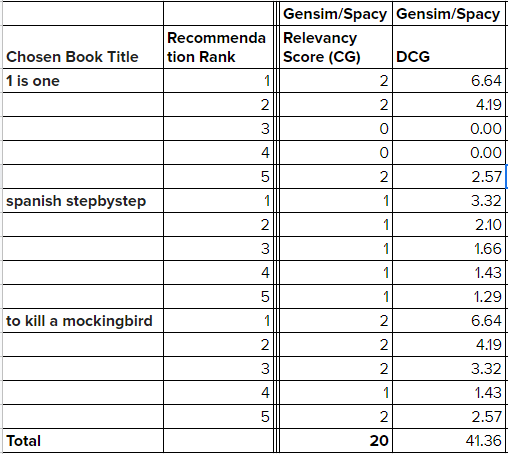

Please see the recommendation lists for these books in the above codes.

